# Практическая работа №3: Кластерный анализ
Выполнил студент гр. 0373 Савинов Алексей. Вариант №18

## Цель работы
Освоение основных понятий и некоторых методов кластерного анализа, в частности, метода k-means и метода поиска сгущений.

## Основные теоретические положения

- __Кластерный анализ__ - задача разбиения выборки на подмножества, называемых кластерами, так, чтобы каждый кластер состоял из схожих объектов, а объекты разных кластеров существенно различались. Задача кластеризации относится к классу задач по обучению без учителя.
- __Нормализация__: $\widetilde{x_i} = \frac{x_i - \mu_x}{\sigma_x}$, где $\mu_x$ - выборочное среднее, $\sigma_x$ - СКО.
- __Евклидово расстояние__: $d(x, y) = \sqrt{\sum_{i=1}^{n}{(x_i - y_i)^2}}$.
- __Грубая верхняя оценка числа кластеров__: $k = \lfloor \sqrt{\frac{n}{2}} \rfloor$.
- __Алгоритм k-Medians__: суть заключается в минимизации суммарного отклонения точек кластеров от центров этих кластеров.
- __Алгоритм k-Medoids__: идентичен алгоритму k-Means за исключением того, что в качестве центра выбирается один из объектов кластера.
- __Метод локтя__: заключается в многократном повторении одного из алгоритмов кластеризации с увеличением количества кластеров. На каждом шаге вычисляется разброс, $W_{c_j} = \sum_{x_i \in C_j}{(x_j - x_{C_j})^2}$, разброс стремится к нулю при увеличении количества кластеров. Оптимальное количество кластеров выбирается в точке перегиба полученной функции.
- __Алгоритм поиска сгущений (FOREL)__: В ходе работы алгоритма исходное множество $X$ разбивается на кластеры с радиусом $R$. Для этого на каждом шаге выбирается случайным образом точка, вокруг нее раздувается гиперсфера радиуса $R$, все точки, попавшие в эту гиперсферу, объединяются в один кластер. Центр этого кластера перемещается в точку со средним значением координат точек кластера. Если после исключения полученного кластера остаются необработанные точки, переходим к следующей итерации алгоритма.

## Постановка задачи
Дано конечное множество из объектов, представленных двумя признаками (в качестве этого множества принимаем исходную двумерную выборку, сформированную ранее в практической работе №2). Выполнить разбиение исходного множества объектов на конечное число подмножеств (кластеров) с использованием метода k-means и метода поиска сгущений. Полученные результаты содержательно проинтерпретировать. Дано конечное множество из объектов, представленных двумя признаками (в качестве этого множества принимаем исходную двумерную выборку, сформированную ранее в практической работе №2). Выполнить разбиение исходного множества объектов на конечное число подмножеств (кластеров) с использованием метода k-means и метода поиска сгущений. Полученные результаты содержательно проинтерпретировать.

## Выполнение работы

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import random
from IPython.display import HTML, Math
from pandas import option_context

In [2]:
disp_pres = 2
pd.set_option(f"display.float_format", f"{{:.{disp_pres}f}}".format)

In [3]:
def tex_format(array, tag):
    nparray = np.array(array)
    start_item = "$$\\" + tag + "{"
    start = np.full((len(nparray)), "$$\\" + tag + "{")
    finish = np.full((len(nparray)), "}$$")
    return np.core.defchararray.add(
        np.core.defchararray.add(start, nparray.astype(str)), finish
    )

### Нормализовать множество точек из предыдущей работы, отобразить полученное множество

In [4]:
def get_sample(path_to_sample, column):
    return pd.read_csv(path_to_sample)[column].to_numpy()

def get_mean(sample):
    return np.sum(sample) / len(sample)

def get_var(sample):
    samp_mean = get_mean(sample)
    return np.sum((sample - samp_mean) ** 2) / len(sample)

def get_std(sample):
    return np.sqrt(get_var(sample))

def normalize_sample(sample):
    return (sample - get_mean(sample)) / get_std(sample)

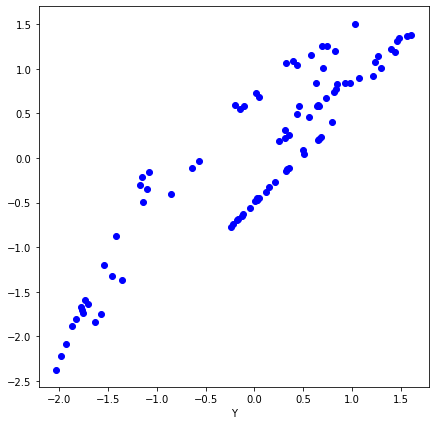

In [5]:
x_sample = get_sample("Данные для практических работ.csv", "Численность мужчин")
y_sample = get_sample("Данные для практических работ.csv", "Численность женщин")
x_norm_sample = normalize_sample(x_sample)
y_norm_sample = normalize_sample(y_sample)
norm_sample = np.vstack([x_norm_sample, y_norm_sample])
plt.figure(figsize=(7, 7))
plt.xlabel('X')
plt.xlabel('Y')
plt.scatter(x_norm_sample, y_norm_sample, color='blue')
plt.show()

### Определить «грубую» верхнюю оценку количества кластеров $\boldsymbol{\tilde k}$

In [6]:
def rough_upper_bound(n):
    return math.floor((n / 2) ** (1/2))

In [7]:
display(Math('\widetilde{k}: ' + str(rough_upper_bound(len(x_norm_sample)))))

<IPython.core.display.Math object>

###  Реализовать алгоритм k-means. Отобразить полученные кластеры, каждый кластер выделить разным цветом или маркером, отметить центроиды

In [8]:
def clustering(points, centers, distance_func, centers_calc_func, treshold=0):
    centers_var = np.copy(centers)
    num_clusters = np.ma.size(centers, axis=1)
    num_points = np.ma.size(points, axis=1)
    center_bias = None
    labels = None
    while center_bias == None or center_bias > treshold:
        distances = np.array([distance_func(
            points, centers_var[:, center_idx, np.newaxis]
        ) for center_idx in range(num_clusters)])
        labels = np.argmin(distances, axis=0)
        new_centers = centers_calc_func(points, labels, centers_var)
        center_bias = np.sum(distance_func(centers_var, new_centers))
        centers_var = new_centers
    return centers_var, labels

In [9]:
# метрика
def distance2d(x1, y1, x2, y2):
    return ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** (1/2)

def distance(fir_points, sec_points):
    return np.sum((fir_points - sec_points) ** 2, axis=0) ** (1/2)

In [10]:
# функция персчета центров
def getKMeansNewCenters(points, labels, centers):
    assert np.ma.size(points, axis=1) == len(labels)
    new_centers = np.copy(centers)
    for i in range(np.ma.size(centers, axis=1)):
        ids = np.where(labels == i)[0]
        if len(ids) > 0:
            new_centers[:, i] = np.mean(points[:, ids], axis=1)
    return new_centers


In [11]:
def showClusters(x, y, xc, yc, labels, figure_size=10):
    num_clusters = len(xc)
    colors = np.random.random((num_clusters, 3))
    plt.figure(figsize=(figure_size, figure_size))
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.xlim(-2.5, 1.8)
    plt.ylim(-2.5, 1.8)
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    for i in range(len(labels)):
        plt.scatter(x[i], y[i], color=colors[labels[i]], s=20)
    for i in range(len(xc)):
        plt.scatter(xc[i], yc[i], color=colors[i], marker='X', s=80, edgecolors='black')
    plt.show()

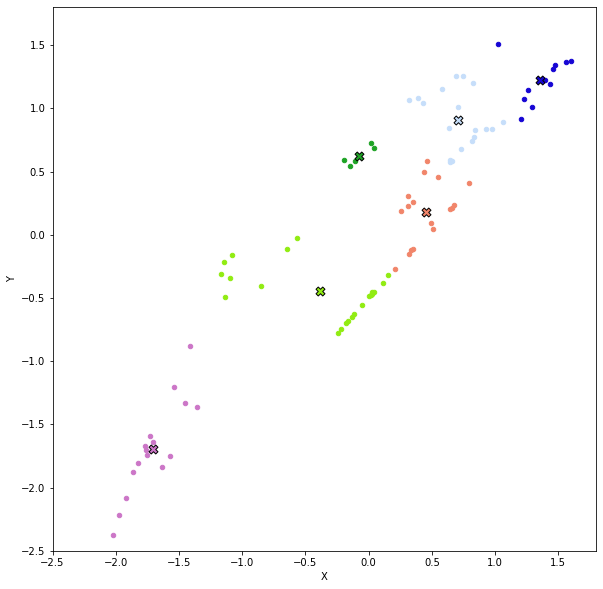

In [12]:
k = rough_upper_bound(len(x_norm_sample))
np.random.seed(0)
centers = [[np.min(x_norm_sample)], [np.min(y_norm_sample)]] + \
    np.random.rand(2, k) * \
    [[np.max(x_norm_sample) - np.min(x_norm_sample)], 
     [np.max(y_norm_sample) - np.min(y_norm_sample)]]
new_centers, labels = clustering(norm_sample, centers,
                                 distance, getKMeansNewCenters)
showClusters(x_norm_sample, y_norm_sample, 
             new_centers[0], new_centers[1], labels)

### Реализовать алгоритмы k-medians (для нечётных вариантов) и k-medoids (для чётных вариантов). Отобразить полученные кластеры, каждый кластер выделить разным цветом или маркером, отметить центроиды

Вариант 18, реализуем алгоритм k-medoids

In [13]:
def getMedoid(points):
    return np.argmin([np.sum(distance(points, points[:, i, np.newaxis])) \
        for i in range(np.ma.size(points, axis=1))])

def getKMedoidsNewCenters(points, labels, centers):
    assert np.ma.size(points, axis=1) == len(labels)
    new_centers = np.copy(centers)
    for i in range(np.ma.size(centers, axis=1)):
        ids = np.where(labels == i)[0]
        if len(ids) > 0:
            medoid_id = getMedoid(points[:, ids])
            new_centers[:, i] = points[:, ids][:, medoid_id]
        else:
            new_centers[:, i] = centers[:, i]
    return new_centers

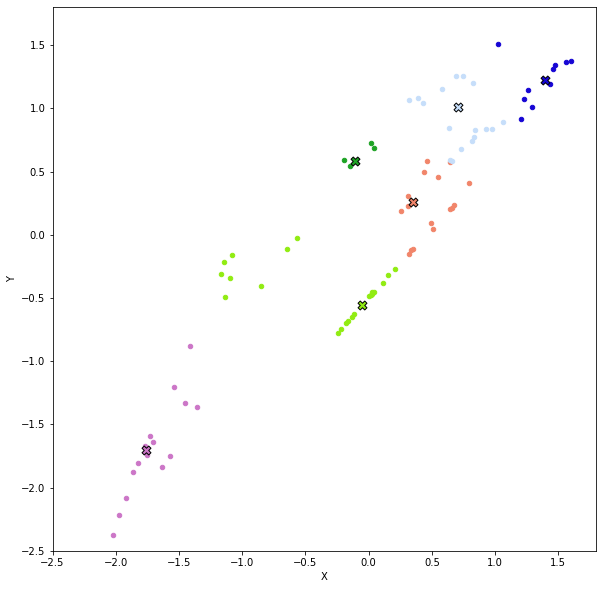

In [14]:
k = rough_upper_bound(len(x_norm_sample))
np.random.seed(0)
centers = [[np.min(x_norm_sample)], [np.min(y_norm_sample)]] + \
    np.random.rand(2, k) * \
    [[np.max(x_norm_sample) - np.min(x_norm_sample)], 
     [np.max(y_norm_sample) - np.min(y_norm_sample)]]
new_centers, labels = clustering(norm_sample, centers,
                                 distance, getKMedoidsNewCenters)
showClusters(x_norm_sample, y_norm_sample, 
             new_centers[0], new_centers[1], labels)

### Для каждого метода заполнить следующую таблицу, где значения $\boldsymbol k$ изменяются от $\boldsymbol 1$ до $\boldsymbol{\tilde k}$

In [15]:
k_ = rough_upper_bound(len(x_norm_sample))
centers_log = []
points_capacity_log = []
for i in range(1, k_+1):
    centers = [[np.min(x_norm_sample)], [np.min(y_norm_sample)]] + \
    np.random.rand(2, i) * \
    [[np.max(x_norm_sample) - np.min(x_norm_sample)], 
     [np.max(y_norm_sample) - np.min(y_norm_sample)]]
    new_centers, labels = clustering(norm_sample, centers,
                                     distance, getKMeansNewCenters)
    centers_str = ', '.join([f'({np.round(new_centers[0, i], disp_pres)}, \
{np.round(new_centers[1, i], disp_pres)})' 
                             for i in range(np.ma.size(new_centers, axis=1))])
    points_capacity_str = ', '.join([str(len(np.where(labels == i)[0])) 
                                     for i in range(np.ma.size(new_centers, axis=1))])
    centers_log.append(centers_str)
    points_capacity_log.append(points_capacity_str)

tab = pd.DataFrame(
    {
        '$$k$$': np.arange(1, k_+1),
        '$$x_{C_i}$$': centers_log,
        '$$\#C_i$$': points_capacity_log
    }
)
print('Таблица для k-Means')
display(HTML(tab.to_html(index=False)))

Таблица для k-Means


$$k$$,$$x_{C_i}$$,$$\#C_i$$
1,"(-0.0, 0.0)",90
2,"(-1.43, -1.27), (0.52, 0.46)","24, 66"
3,"(0.61, 0.57), (-1.16, -1.09), (1.4, -0.68)","59, 31, 0"
4,"(0.51, -1.56), (-1.71, -1.69), (-0.26, -0.38), (0.73, 0.8)","0, 16, 27, 47"
5,"(0.04, -1.75), (0.72, 0.78), (1.56, -1.39), (-0.28, -0.4), (-1.71, -1.69)","0, 48, 0, 26, 16"
6,"(-1.45, 0.81), (-1.73, -1.75), (0.85, 0.95), (-1.01, -0.33), (-1.31, 1.42), (0.14, -0.17)","0, 15, 36, 9, 0, 30"


In [16]:
k_ = rough_upper_bound(len(x_norm_sample))
centers_log = []
points_capacity_log = []
for i in range(1, k_+1):
    centers = [[np.min(x_norm_sample)], [np.min(y_norm_sample)]] + \
    np.random.rand(2, i) * \
    [[np.max(x_norm_sample) - np.min(x_norm_sample)], 
     [np.max(y_norm_sample) - np.min(y_norm_sample)]]
    new_centers, labels = clustering(norm_sample, centers,
                                     distance, getKMedoidsNewCenters)
    centers_str = ', '.join([f'({np.round(new_centers[0, i], disp_pres)}, \
{np.round(new_centers[1, i], disp_pres)})' 
                             for i in range(np.ma.size(centers, axis=1))])
    points_capacity_str = ', '.join([str(len(np.where(labels == i)[0])) 
                                     for i in range(np.ma.size(centers, axis=1))])
    centers_log.append(centers_str)
    points_capacity_log.append(points_capacity_str)


tab = pd.DataFrame(
    {
        '$$k$$': np.arange(1, k_+1),
        '$$x_{C_i}$$': centers_log,
        '$$\#C_i$$': points_capacity_log
    }
)
print('Таблица для k-Medoids')
display(HTML(tab.to_html(index=False)))

Таблица для k-Medoids


$$k$$,$$x_{C_i}$$,$$\#C_i$$
1,"(0.25, 0.19)",90
2,"(0.55, 0.46), (-1.7, -1.64)","68, 22"
3,"(0.0, -0.48), (-1.76, -1.7), (0.73, 0.68)","26, 16, 48"
4,"(0.73, 0.68), (-1.06, 1.23), (-1.76, -1.7), (0.0, -0.48)","48, 0, 16, 26"
5,"(-1.76, -1.74), (0.73, 0.68), (-0.97, -2.35), (-1.09, -0.34), (0.02, -0.47)","15, 48, 0, 9, 18"
6,"(0.64, -1.51), (1.39, 1.22), (-1.76, -1.7), (0.7, 1.01), (0.35, 0.26), (-0.05, -0.56)","0, 11, 16, 18, 22, 23"


### С помощью метода силуэтов (для нечётных вариантов) и метода локтя (для чётных вариантов) выявить для каждого метода оптимальное количество кластеров

Вариант 18, используем метод локтя

Для k-Means


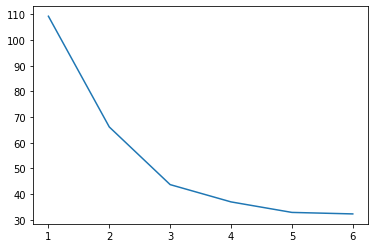

In [17]:
k_ = rough_upper_bound(len(x_norm_sample))
w_log = []
for i in range(1, k_+1):
    centers = [[np.min(x_norm_sample)], [np.min(y_norm_sample)]] + \
    np.random.rand(2, i) * \
    [[np.max(x_norm_sample) - np.min(x_norm_sample)], 
     [np.max(y_norm_sample) - np.min(y_norm_sample)]]
    new_centers, labels = clustering(norm_sample, centers,
                                     distance, getKMeansNewCenters)
    w_log.append(np.sum(
        [np.sum(distance2d(x_norm_sample[np.where(labels == i)[0]], 
                           y_norm_sample[np.where(labels == i)[0]],
                           new_centers[0, i], new_centers[1, i])) 
         for i in range(np.ma.size(new_centers, axis=1))]
    ))

print('Для k-Means')
plt.plot(np.arange(1, k_+1), w_log)
plt.show()

Для k-Medoids


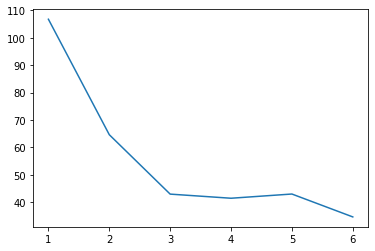

In [18]:
k_ = rough_upper_bound(len(x_norm_sample))
w_log = []
for i in range(1, k_+1):
    centers = [[np.min(x_norm_sample)], [np.min(y_norm_sample)]] + \
    np.random.rand(2, i) * \
    [[np.max(x_norm_sample) - np.min(x_norm_sample)], 
     [np.max(y_norm_sample) - np.min(y_norm_sample)]]
    new_centers, labels = clustering(norm_sample, centers,
                                     distance, getKMedoidsNewCenters)
    w_log.append(np.sum(
        [np.sum(distance2d(x_norm_sample[np.where(labels == i)[0]], 
                           y_norm_sample[np.where(labels == i)[0]],
                           new_centers[0, i], new_centers[1, i])) 
         for i in range(np.ma.size(new_centers, axis=1))]
    ))

print('Для k-Medoids')
plt.plot(np.arange(1, k_+1), w_log)
plt.show()

Судя по графикам, оптимальное количество кластеров для k-Means и k-Medoids - 3 кластера.

### Реализовать алгоритм поиска сгущений при различных радиусах $\boldsymbol R$, отобразить полученные кластеры, выделить каждый кластер разным цветом или маркером, отметить центроиды. Результаты представить в виде таблицы

In [19]:
def forel(points, r):
    points_var = np.copy(points)
    labels = np.full(np.ma.size(points_var, axis=1), -1, dtype=np.int16)
    cl_id = 0
    centers = []
    while len(np.where(~np.isnan(points_var[0, :]))[0]) > 0:
        cent_idx = np.random.choice(np.where(~np.isnan(points_var[0, :]))[0])
        distances = distance(points_var, points_var[:, cent_idx, np.newaxis])
        cl_idxs = np.squeeze(np.argwhere(distances <= r), 1)
        new_cent = np.mean(points_var[:, cl_idxs], axis=1)
        points_var[:, cl_idxs] = np.nan
        labels[cl_idxs] = cl_id
        centers.append(new_cent)
        cl_id += 1
    return np.array(centers).T, labels

In [20]:
distances = [distance2d(x_norm_sample, y_norm_sample, 
                        np.roll(x_norm_sample, i), 
                        np.roll(y_norm_sample, i)) \
             for i in range(len(x_norm_sample)-1)]
r_max = np.max(distances)
r_min = np.min(distances[1:])
display(Math('$$R_{max}: ' + str(round(r_max, disp_pres+2))))
display(Math('$$R_{max}: ' + str(round(r_min, disp_pres+2))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

R: 0.5046


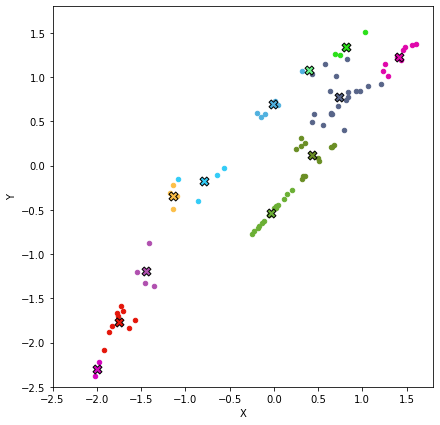

R: 1.1828


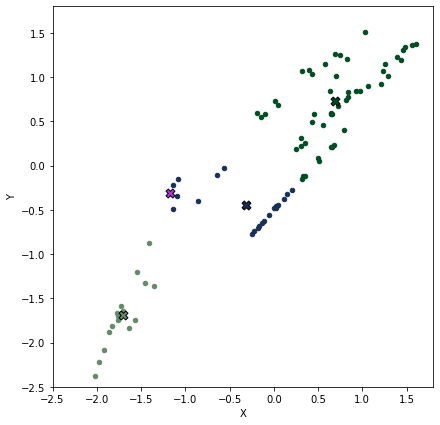

R: 1.861


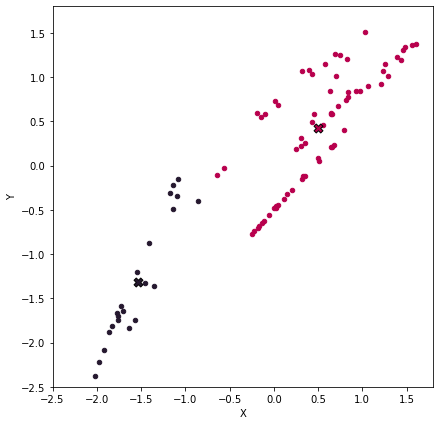

R: 2.5392


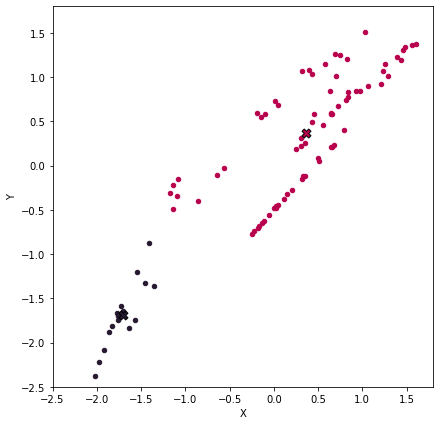

R: 3.2174


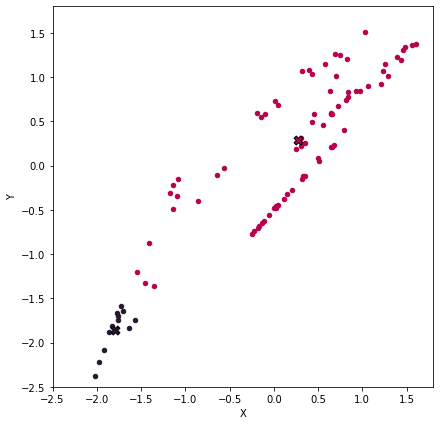

In [21]:
for i in np.linspace(r_min+0.5, r_max-2, 5):
    np.random.seed(1)
    centers, labels = forel(norm_sample, i)
    print('R:', round(i, disp_pres+2))
    showClusters(x_norm_sample, y_norm_sample, centers[0], centers[1], labels, 7)

In [22]:
centers_log = []
points_capacity_log = []
for i in np.linspace(r_min+0.5, r_max-2, 5):
    np.random.seed(1)
    new_centers, labels = forel(norm_sample, i)
    centers_str = ', '.join([f'({np.round(new_centers[0, i], disp_pres)}, \
{np.round(new_centers[1, i], disp_pres)})' 
                             for i in range(np.ma.size(new_centers, axis=1))])
    points_capacity_str = ', '.join([str(len(np.where(labels == i)[0])) 
                                     for i in range(np.ma.size(new_centers, axis=1))])
    centers_log.append(centers_str)
    points_capacity_log.append(points_capacity_str)

tab = pd.DataFrame(
    {
        '$$R$$': np.linspace(r_min+1, r_max-1, 5),
        '$$x_{C_i}$$': centers_log,
        '$$\#C_i$$': points_capacity_log
    }
)
print('Таблица для FOREL')
display(HTML(tab.to_html(index=False)))

Таблица для FOREL


$$R$$,$$x_{C_i}$$,$$\#C_i$$
1.00,"(0.74, 0.77), (-0.03, -0.54), (1.41, 1.23), (0.43, 0.12), (-0.79, -0.18), (-0.01, 0.7), (-1.75, -1.77), (0.82, 1.34), (0.39, 1.08), (-1.44, -1.19), (-2.0, -2.3), (-1.14, -0.34)","20, 15, 9, 12, 4, 6, 10, 3, 1, 4, 2, 4"
1.81,"(0.7, 0.73), (-0.32, -0.45), (-1.71, -1.69), (-1.17, -0.31)","51, 22, 16, 1"
2.61,"(0.5, 0.43), (-1.54, -1.32)","68, 22"
3.41,"(0.37, 0.37), (-1.71, -1.69)","74, 16"
4.22,"(0.28, 0.29), (-1.79, -1.86)","78, 12"


### Проверить чувствительность метода поиска сгущений к погрешностям. Сделать выводы

In [23]:
centers_log = []
points_capacity_log = []
for i in np.linspace(r_min+0.5+0.1, r_max-2+0.1, 5):
    np.random.seed(1)
    new_centers, labels = forel(norm_sample, i)
    centers_str = ', '.join([f'({np.round(new_centers[0, i], disp_pres)}, \
{np.round(new_centers[1, i], disp_pres)})' 
                             for i in range(np.ma.size(new_centers, axis=1))])
    points_capacity_str = ', '.join([str(len(np.where(labels == i)[0])) 
                                     for i in range(np.ma.size(new_centers, axis=1))])
    centers_log.append(centers_str)
    points_capacity_log.append(points_capacity_str)

tab = pd.DataFrame(
    {
        '$$R$$': np.linspace(r_min+1, r_max-1, 5),
        '$$x_{C_i}$$': centers_log,
        '$$\#C_i$$': points_capacity_log
    }
)
print('Таблица для FOREL при радиусе R+0.1')
display(HTML(tab.to_html(index=False)))

Таблица для FOREL при радиусе R+0.1


$$R$$,$$x_{C_i}$$,$$\#C_i$$
1.00,"(0.76, 0.8), (-1.13, -0.4), (-0.05, -0.56), (1.42, 1.33), (-1.92, -2.07), (0.2, 0.24), (-1.63, -1.58), (-0.61, -0.07)","30, 7, 14, 7, 5, 15, 10, 2"
1.81,"(0.68, 0.69), (-0.37, -0.46), (-1.71, -1.69), (-1.17, -0.31)","53, 20, 16, 1"
2.61,"(0.5, 0.43), (-1.54, -1.32)","68, 22"
3.41,"(0.37, 0.37), (-1.71, -1.69)","74, 16"
4.22,"(0.28, 0.29), (-1.79, -1.86)","78, 12"


Для данной выборки алгоритм сильно чувствителен к погрешностям при $R < 1.86$, несильно чувствителен к погрешностям при $R \geq 1.86$

### Сравнить методы. Сделать выводы

Алгоритм k-Means работает более стабильно, чем k-Medoids. Оптимальное число кластеров, найденное для них с помощью метода локтя - 3. Алгоритм поиска сгущений работает стабильно при малом числе кластеров ($k \leq 3$).

## Выводы

В ходе работы было сделано: нормализовано множество точек, реализованы алгоритм k-means и k-medoids, отображены полученные кластеры, построены таблицы, показывающие изменения параметров кластеров в зависимости от их числа, с помощью метода локтя выявлено оптимальное количество кластеров для каждого метода, реализован алгоритм поиска сгущений при различных радиусах $R$, отображены полученные кластеры, построена таблица характеристик.